# Homework09

Exercises to practice dimensionality reduction with PCA

## Goals

- Add unsupervised pre-processing to our ML flow: encode -> normalize -> pre-process -> train -> evaluate
- Build an intuition for PCA and when/how to use it
- Understand the benefits of dimensionality reduction

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/Homework07/raw/main/Homework07_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/0801-500.tar.gz | tar xz

In [2]:
import PIL.Image as PImage

import pandas as pd

from os import listdir, path

from data_utils import PCA, RandomForestClassifier, StandardScaler, SVC, TSNE

from image_utils import get_pixels, make_image

from Homework07_utils import CamUtils

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same one we used in `Homework07`. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/image/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [3]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/image/0801-500/train") if f.endswith(".jpg")]

In [5]:
# TODO: check and see what is inside the list here
display(train_files)

['17-85.jpg',
 '26-29.jpg',
 '07-11.jpg',
 '13-47.jpg',
 '23-73.jpg',
 '27-15.jpg',
 '11-94.jpg',
 '21-51.jpg',
 '02-48.jpg',
 '09-48.jpg',
 '23-28.jpg',
 '23-41.jpg',
 '25-71.jpg',
 '24-09.jpg',
 '07-75.jpg',
 '18-31.jpg',
 '10-50.jpg',
 '26-16.jpg',
 '07-31.jpg',
 '09-62.jpg',
 '21-08.jpg',
 '26-61.jpg',
 '17-66.jpg',
 '27-47.jpg',
 '13-56.jpg',
 '21-60.jpg',
 '05-15.jpg',
 '02-36.jpg',
 '31-20.jpg',
 '31-08.jpg',
 '15-30.jpg',
 '18-10.jpg',
 '02-14.jpg',
 '22-00.jpg',
 '26-35.jpg',
 '09-04.jpg',
 '26-50.jpg',
 '01-38.jpg',
 '10-43.jpg',
 '22-53.jpg',
 '10-48.jpg',
 '18-29.jpg',
 '15-22.jpg',
 '07-85.jpg',
 '17-81.jpg',
 '24-52.jpg',
 '18-21.jpg',
 '28-69.jpg',
 '02-21.jpg',
 '23-64.jpg',
 '23-51.jpg',
 '06-30.jpg',
 '31-21.jpg',
 '19-30.jpg',
 '02-40.jpg',
 '07-15.jpg',
 '10-61.jpg',
 '18-03.jpg',
 '08-35.jpg',
 '19-37.jpg',
 '05-42.jpg',
 '05-49.jpg',
 '21-15.jpg',
 '05-25.jpg',
 '15-07.jpg',
 '12-06.jpg',
 '27-05.jpg',
 '17-54.jpg',
 '08-50.jpg',
 '08-22.jpg',
 '22-14.jpg',
 '02-0

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [6]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = PImage.open(path.join("./data/image/0801-500/train", fname))
  pixel_data.append(get_pixels(img))
  label_data.append(label)

In [7]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list

display(label_data)

[13,
 21,
 5,
 11,
 18,
 22,
 9,
 16,
 1,
 7,
 18,
 18,
 20,
 19,
 5,
 14,
 8,
 21,
 5,
 7,
 16,
 21,
 13,
 22,
 11,
 16,
 3,
 1,
 24,
 24,
 12,
 14,
 1,
 17,
 21,
 7,
 21,
 0,
 8,
 17,
 8,
 14,
 12,
 5,
 13,
 19,
 14,
 23,
 1,
 18,
 18,
 4,
 24,
 15,
 1,
 5,
 8,
 14,
 6,
 15,
 3,
 3,
 16,
 3,
 12,
 10,
 22,
 13,
 6,
 6,
 17,
 1,
 22,
 0,
 10,
 18,
 23,
 16,
 8,
 12,
 11,
 2,
 13,
 21,
 17,
 10,
 4,
 7,
 2,
 21,
 11,
 4,
 19,
 7,
 15,
 10,
 18,
 20,
 17,
 6,
 17,
 2,
 21,
 0,
 2,
 21,
 15,
 14,
 20,
 2,
 20,
 13,
 21,
 13,
 20,
 5,
 17,
 10,
 0,
 22,
 7,
 3,
 23,
 8,
 10,
 10,
 11,
 7,
 9,
 4,
 17,
 18,
 15,
 11,
 14,
 10,
 8,
 3,
 24,
 15,
 9,
 4,
 19,
 19,
 23,
 23,
 19,
 16,
 6,
 24,
 20,
 6,
 13,
 12,
 3,
 22,
 8,
 23,
 23,
 7,
 5,
 22,
 22,
 11,
 8,
 16,
 13,
 10,
 9,
 9,
 2,
 6,
 16,
 12,
 22,
 20,
 0,
 15,
 6,
 9,
 5,
 0,
 9,
 1,
 24,
 19,
 16,
 8,
 19,
 17,
 1,
 19,
 3,
 7,
 17,
 23,
 12,
 9,
 15,
 11,
 12,
 18,
 4,
 9,
 2,
 14,
 1,
 15,
 11,
 14,
 6,
 4,
 2,
 2,
 2,
 20,
 6,
 

Like in `Homework07`, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

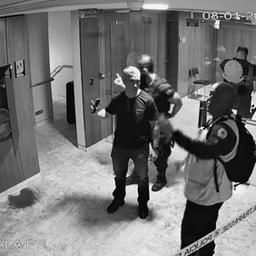

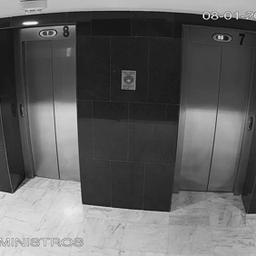

In [8]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did in Homewokr07 with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `Homework07`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [10]:
# TODO: run PCA, get DataFrame
pca = PCA(n_components=12)
pca_result = pca.fit_transform(pixel_data)

cam_pca_df = pd.DataFrame(pca_result)

# TODO: add "label" column
cam_pca_df["label"] = label_data
cam_pca_df.head()
# TODO: print variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
# TODO: take a look at the first 5 rows
print(cam_pca_df.head())

Explained variance ratio: [0.24273758 0.14776564 0.12324789 0.08042213 0.05193327 0.03765846
 0.03234669 0.02826384 0.02169188 0.01918686 0.01578644 0.01436768]
           PC0          PC1          PC2          PC3          PC4  \
0  1211.783230   877.945502 -2586.613110  5250.305548  2018.252884   
1  4362.018543  -249.771418  3036.742720  3715.018330  -845.729367   
2 -2187.666720 -8270.230054  9307.806825 -6118.796975 -3623.729138   
3 -4669.555572 -5856.007913   289.554543  5548.766836 -2111.406884   
4  1670.591181 -6361.599954 -3268.298514  8846.542068  1572.842852   

           PC5          PC6          PC7          PC8          PC9  \
0  1691.885668   760.709599  1184.201369   444.376392   156.909656   
1   602.730859 -2545.029804 -3608.097932  -183.775969   140.840359   
2 -1108.252625 -2116.141066  3221.049545 -2980.632067 -4233.246119   
3 -2685.842885  4713.121824  4217.379606  -511.435995  2085.145871   
4  6545.545371  3806.842810 -1329.323907 -1578.328719 -2953.108003  

### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

In [11]:
# How many components did you keep?
num_components = pca.n_components_
print("Number of components kept:", num_components)

Number of components kept: 12


In [12]:
# What percent of variance is kept by this transformation?
total_variance = sum(pca.explained_variance_ratio_)
print(f"Total variance explained: {total_variance:.2%}")

# I found out that keeping n=8 we get a total variance of 74.44%, while 10 gives us 78.53%. n=12 gives us 81.54%. 


Total variance explained: 81.54%


### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

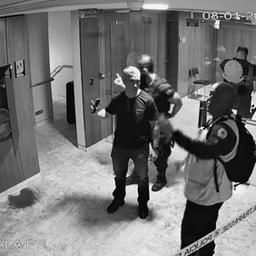

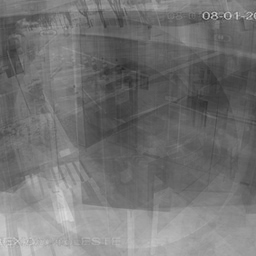

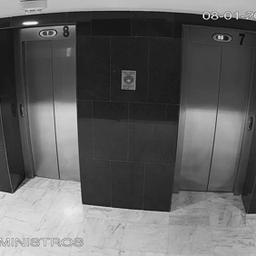

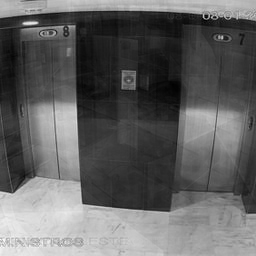

In [13]:
pca_pixels = pca.inverse_transform(cam_pca_df)
iw, ih = img.size
# TODO: reconstruct image at index 0
display(make_image(pixel_data[0], width=iw))
display(make_image(pca_pixels.loc[0], width=iw))

# TODO: reconstruct image at index 10
display(make_image(pixel_data[10], width=iw))
display(make_image(pca_pixels.loc[10], width=iw))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [14]:
# TODO: create a 
mClassifier = RandomForestClassifier()
# TODO: split input and output features
train_feats = cam_pca_df.drop(columns=["label"])
train_labels = cam_pca_df["label"]
# TODO: fit the model
mClassifier.fit(train_feats, train_labels)
# TODO: run predictions
train_predictions = mClassifier.predict(train_feats)

### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [15]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Run on Test set

Now we'll open the image files inside the `./data/image/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [16]:
# TODO: create a list of files in the test/ directory
test_files = []

# TODO: check its length and content

test_feats = cam_pca_df.drop(columns=["label"])
test_labels = cam_pca_df["label"]

mClassifier.fit(test_feats, test_labels)
# TODO: run predictions
test_predictions = mClassifier.predict(test_feats)

We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [17]:
test_pixel_data = []

for fname in test_files:
  img = PImage.open(path.join("./data/image/0801-500/test", fname))
  test_pixel_data.append(get_pixels(img))

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [ ]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one

It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

In [ ]:
# TODO: reconstruct one or two images

# TODO: take a look at the first 5 rows

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [ ]:
# TODO: run classifier. This is the same classifier already fitted on the train data above

# TODO: get accuracy

### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to the classification model from <code>Homework07</code>? They can both be tuned to perform well, but how many features did we need last time in order to get an accuracy comparable to this?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>